## Example 5.2 Euler beams

using a julia 1.2.0 kernel

In [1]:
using PyPlot, MAT
;

In [2]:
using AD4SM
;

In [3]:
mean(x) = sum(x)/length(x)

#=  
makeHexaModels is a helper function to create a N1xN2 
hexagonal lattice with side length L0
=#
function makeHexaModels(;N1 = 5, N2=5, L0=1, dTol=1e-6)

  # unit cell and periodic directions
  a1 = sqrt(3)L0.*(cos(π/6), sin(π/6))
  a2 = sqrt(3)L0.*(cos(π/6), -sin(π/6))
  p0 = [[cos(θ)L0, sin(θ)L0] for θ = range(0, stop=5π/3, length=6)]

  # replicate the nodes
  nodes = []
  for jj in  range(1, stop=N2)
    for ii in range(0, stop=N1-1)
      Δ = a1.*floor(ii/2) .+ a2.*ceil(ii/2) .+ (jj-1).*(a1.-a2)
      for item in p0
        push!(nodes, [item[1]+Δ[1], item[2]+Δ[2]])
      end
    end
  end

  #remove duplicated nodes
  global jj = 1
  while jj < length(nodes)
    rmidx = []
    for (ii, p0) in enumerate(nodes[jj+1:end])
      dd = sqrt((p0[1]-nodes[jj][1])^2 + (p0[2]-nodes[jj][2])^2) 
      (dd <= dTol) && push!(rmidx, ii)        
    end
    deleteat!(nodes, jj.+rmidx)
    jj+=1    
  end

  # add beams
  jj    = 1
  beams = []
  while jj < length(nodes)
    for (ii, p0) in enumerate(nodes[jj+1:end])
      dd = sqrt((p0[1]-nodes[jj][1])^2 + (p0[2]-nodes[jj][2])^2) 
      (abs(dd-L0) <= dTol) && push!(beams, [jj, jj+ii])
    end
    jj+=1    
  end

  return (nodes, beams)
end
;

In [4]:
@time (nodes, beams) = makeHexaModels(N1 = 21, N2 = 21, L0 = 1.2)

nNodes   = length(nodes)
t, w, Es = .1, .1, 5
A        = t*w
elems    = [Elements.Beam(beam, nodes[beam], t, w,
    mat=Materials.Hooke(Es, 0.3)) for beam in beams]
;

  2.936453 seconds (34.10 M allocations: 739.497 MiB, 7.92% gc time)


In [5]:
minx = minimum([node[1] for node in nodes])
maxx = maximum([node[1] for node in nodes])
miny = minimum([node[2] for node in nodes])
maxy = maximum([node[2] for node in nodes])


idbtm = findall(abs.([node[2] for node in nodes].-miny) .<1e-6)
idtop = findall(abs.([node[2] for node in nodes].-maxy) .<1e-6)

LY    = maxy-miny
;

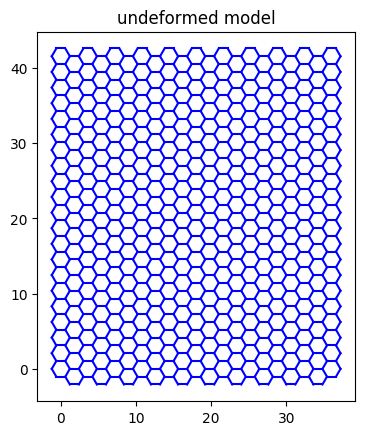

In [6]:
ax = getproperty(figure(),:add_subplot)(1,1,1)
for item in beams
    n1 = nodes[item[1]]
    n2 = nodes[item[2]]
    PyPlot.plot(
        [n1[1], n2[1]], 
        [n1[2], n2[2]],
        markersize=1, color=:b)
end
getproperty(ax, :set_aspect)("equal")
title("undeformed model")
;

Add initial and boudary conditions

In [7]:
u     = fill!(zeros(3, nNodes), NaN)
ΔY    = 0.75LY

u[:,idbtm] .= 0.0
u[:,idtop] .= 0.0
u[2,idtop] .= ΔY
;

In [8]:
bfreeu = isnan.(u)
uold   = zeros(size(u))
unew   = zeros(size(u))
unew[.!bfreeu] .= u[.!bfreeu]*1e-4

fe    = zeros(length(unew))
;

In [9]:
allus = Solvers.solve(elems, u, N=20, bprogress=false, bechoi=false, becho=true, ballus=true)
;

step   1/20, LF=0.000, done in  1 iter, after 3.61 sec.
step   2/20, LF=0.053, done in  4 iter, after 1.50 sec.
step   3/20, LF=0.105, done in  4 iter, after 1.41 sec.
step   4/20, LF=0.158, done in  4 iter, after 1.42 sec.
step   5/20, LF=0.211, done in  3 iter, after 1.09 sec.
step   6/20, LF=0.263, done in  3 iter, after 1.21 sec.
step   7/20, LF=0.316, done in  3 iter, after 1.08 sec.
step   8/20, LF=0.368, done in  3 iter, after 1.10 sec.
step   9/20, LF=0.421, done in  3 iter, after 1.15 sec.
step  10/20, LF=0.474, done in  2 iter, after 0.84 sec.
step  11/20, LF=0.526, done in  2 iter, after 0.86 sec.
step  12/20, LF=0.579, done in  2 iter, after 0.85 sec.
step  13/20, LF=0.632, done in  2 iter, after 0.94 sec.
step  14/20, LF=0.684, done in  2 iter, after 0.79 sec.
step  15/20, LF=0.737, done in  2 iter, after 0.86 sec.
step  16/20, LF=0.789, done in  2 iter, after 0.81 sec.
step  17/20, LF=0.842, done in  2 iter, after 1.07 sec.
step  18/20, LF=0.895, done in  2 iter, after 0.

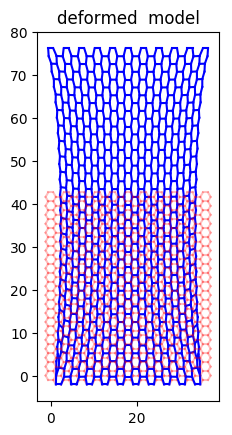

In [10]:
unew = allus[end][1]
ax   = getproperty(figure(),:add_subplot)(1,1,1)

for beam in beams
    n1, n2 = nodes[beam]
    u1 = unew[:,beam[1]]
    u2 = unew[:,beam[2]]    
    
    PyPlot.plot(
        [n1[1], n2[1]], 
        [n1[2], n2[2]],
        markersize=1, color=:r, alpha=0.25)
    PyPlot.plot(
        [n1[1]+u1[1], n2[1]+u2[1]], 
        [n1[2]+u1[2], n2[2]+u2[2]],
        markersize=1, color=:b)
end
getproperty(ax, :set_aspect)("equal")
title("deformed  model")
;

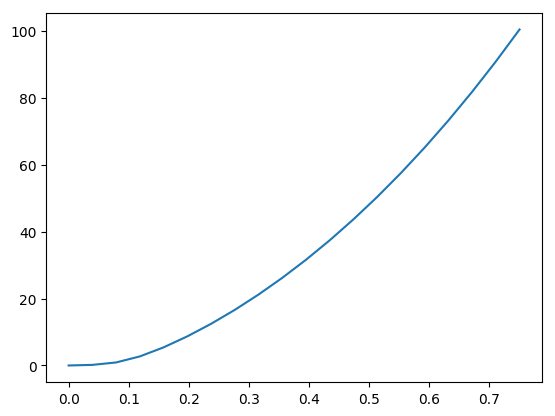

In [11]:
idd = LinearIndices(u)[2,idtop]

RY  = [sum(u[2][idd]) for u in allus];
Δu  = [mean(u[1][idd]) for u in allus]

PyPlot.plot(Δu/LY, RY/Es/A)
;

In [12]:
matwrite("HexaLattice.mat", Dict(
  "Ry"     => RY,
  "nodes"  => hcat(nodes[:]...)|> transpose |> collect, 
  "beams"  => hcat(beams[:]...)|> transpose |> collect, 
  "LY"     => LY,
  "DeltaY" => Δu, 
  "u"      => unew,
  "Es"     => Float64(Es),
  "A"      => A))